# Steps for image recreation:
## 1. Grab image you want to perform style transfer on and create function to preprocess and un-preprocess the image.
## 2. Get VGG_Avg model and grab the activations from the 5th block of the convolutional layer.
## 3. Create a model with the input being the input to the VGG and the output being the activations to this conv layer that we grabbed in step 2.
## 4. Create an evaluator object which knows how to return the loss function and the gradients.
## 5. Create the solve image function which updates x and saves a copy of it to a folder.
## 6. Generate a random image and run solve image on it

In [1]:
path = '../data/datasets/imagenet/sample/'

In [29]:
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from vgg16_avg import VGG16_Avg
import keras
from keras import Model
from keras import backend as K
from keras import metrics
from scipy.optimize import fmin_l_bfgs_b
import scipy
from PIL import Image
from keras_tqdm import TQDMNotebookCallback
import sys
import imageio

In [19]:
os.path.isdir(path)

True

In [20]:
file_names = glob.glob(path+'**/*.JPEG', recursive=True)
len(file_names)

19439

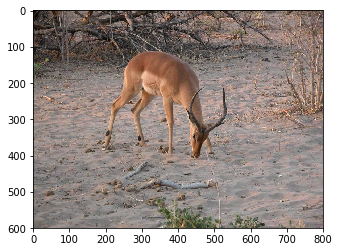

In [21]:
file_to_transfer = file_names[62]
img = mpimg.imread(file_to_transfer)
imgplot = plt.imshow(img)
plt.show()

# Preprocess image

In [22]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda pic: (pic - rn_mean)[:, :, :, ::-1]
deproc = lambda pic, shape: np.clip(pic.reshape(shape)[:, :, :, ::-1] + rn_mean, 0, 255)

In [23]:
img_arr = preproc(np.expand_dims(np.array(img), 0))
shp = img_arr.shape

## 2. Get VGG_Avg model and grab the activations from the 5th block of the convolutional layer.


In [24]:
model = VGG16_Avg(include_top=False)

/Users/aashish/Developer/Python/local_fast.ai_pt2/deeplearning2/vgg16_avg.py:48: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="block1_conv1", padding="same")`
  x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv1')(img_input)
/Users/aashish/Developer/Python/local_fast.ai_pt2/deeplearning2/vgg16_avg.py:49: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="block1_conv2", padding="same")`
  x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv2')(x)
/Users/aashish/Developer/Python/local_fast.ai_pt2/deeplearning2/vgg16_avg.py:53: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="block2_conv1", padding="same")`
  x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv1')(x)
/Users/aashish/Developer/Python/local_fast.ai_pt2/deeplearni

In [25]:
output_activations = model.get_layer('block5_conv1').output

## 3. Create a model with the input being the input to the VGG and the output being the activations to this conv layer that we grabbed in step 2.


In [26]:
layer_model = Model(model.input, output_activations)
targ = K.variable(layer_model.predict(img_arr))

## 4. Create an evaluator object which knows how to return the loss function and the gradients.


In [27]:
class Evaluator(object):
    def __init__(self, f, shp): self.f, self.shp = f, shp
    
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)
    
    def grads(self, x): return self.grad_values.flatten().astype(np.float64)

In [28]:
loss = K.mean(metrics.mse(output_activations, targ))
grads = K.gradients(loss, model.input)
fn = K.function([model.input], [loss] + grads)
evaluator = Evaluator(fn, shp)

In [30]:
def solve_content(eval_obj, niter, initial_image):
    for i in range(niter):
        initial_image, min_loss, info = fmin_l_bfgs_b(eval_obj.loss, initial_image.flatten(), fprime=eval_obj.grads, maxfun=20)
        
        initial_image = np.clip(initial_image, -127, 127)
        print('Current loss value:', min_loss)
        imageio.imwrite(f'{path}results/res_at_iteration_content_{i}.png', deproc(initial_image.copy(), shp)[0])
    return initial_image

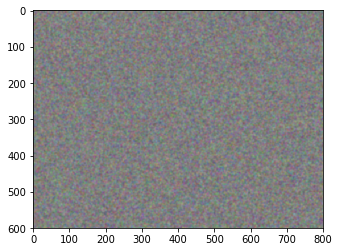

In [31]:
rand_img = lambda shape: np.random.uniform(0, 100, shape) / 100
x = rand_img(shp)
x = scipy.ndimage.filters.gaussian_filter(x, [0, 2, 2, 0])
plt.imshow(x[0])

In [32]:
iterations = 1

In [33]:
x = solve_content(evaluator, iterations, x)

Current loss value: 21.58019256591797


/Users/aashish/anaconda2/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [0.0, 217.5801861717727]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


# Time to do the exact same thing with the style

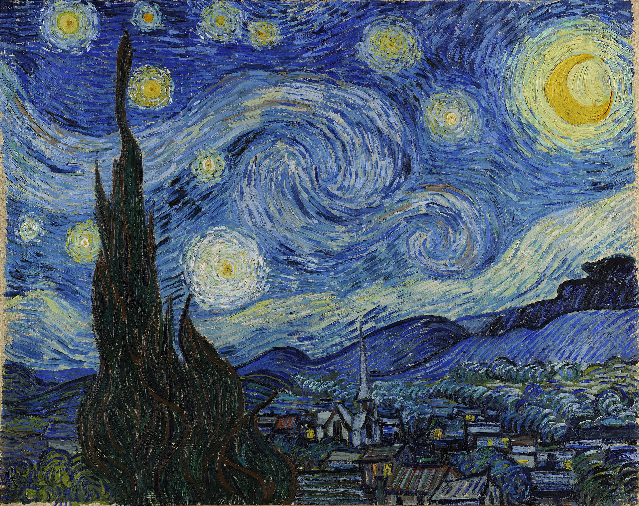

In [34]:
style = Image.open('starry_night.jpg')
style = style.resize(np.divide(style.size,3).astype('int32')); style

Preprocess style image

In [35]:
style_arr = preproc(np.expand_dims(style,0)[:,:,:,:3])
shp = style_arr.shape; shp

(1, 506, 639, 3)

In [36]:
model = VGG16_Avg(include_top=False, input_shape=shp[1:])
outputs = {l.name: l.output for l in model.layers}

/Users/aashish/Developer/Python/local_fast.ai_pt2/deeplearning2/vgg16_avg.py:48: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="block1_conv1", padding="same")`
  x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv1')(img_input)
/Users/aashish/Developer/Python/local_fast.ai_pt2/deeplearning2/vgg16_avg.py:49: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="block1_conv2", padding="same")`
  x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv2')(x)
/Users/aashish/Developer/Python/local_fast.ai_pt2/deeplearning2/vgg16_avg.py:53: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="block2_conv1", padding="same")`
  x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv1')(x)
/Users/aashish/Developer/Python/local_fast.ai_pt2/deeplearni

In [37]:
layers = [outputs['block{}_conv1'.format(o)] for o in range(1, 3)]

In [38]:
layer_model = Model(model.input, layers)
targs = [K.variable(o) for o in layer_model.predict(style_arr)]

In [39]:
def gram_matrix(x): 
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

In [40]:
def style_loss(x, targ):
    return K.mean(metrics.mse(gram_matrix(x), gram_matrix(targ)))

In [41]:
loss = sum(style_loss(l1[0], l2[0]) for l1, l2 in zip(layers, targs))
grads = K.gradients(loss, model.input)
style_fn = K.function([model.input], [loss] + grads)
evaluator = Evaluator(style_fn, shp)

In [42]:
rand_img = lambda shape: np.random.uniform(0, 100, shape)/100
x = rand_img(shp)
x = scipy.ndimage.filters.gaussian_filter(x, [0,2,2,0])

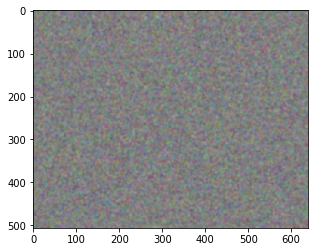

In [43]:
plt.imshow(x[0])

In [47]:
iterations=1
x = rand_img(shp)

In [48]:
def solve_style(eval_obj, niter, initial_image):
    for i in range(niter):
        initial_image, min_loss, info = fmin_l_bfgs_b(eval_obj.loss, initial_image.flatten(), fprime=eval_obj.grads, maxfun=20)
        
        initial_image = np.clip(initial_image, -127, 127)
        print('Current loss value:', min_loss)
        imageio.imwrite(f'{path}results/res_at_iteration_style_{i}.png', deproc(initial_image.copy(), shp)[0])
    return initial_image

In [49]:
x = solve_style(evaluator, iterations, x)

Current loss value: 17067.87109375


/Users/aashish/anaconda2/envs/python3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [0.0, 243.77899932861328]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


# Solve the style using the solve_style function

# Creating neural style transfer

In [50]:
def plot_arr(arr): plt.imshow(deproc(arr,arr.shape)[0].astype('uint8'))

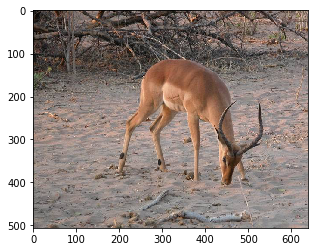

In [51]:
w, h = style.size
src = img_arr[:, :h, :w]
plot_arr(src)

In [52]:
style_layers = [outputs['block{}_conv2'.format(o)] for o in range(1, 6)]
content_name = 'block4_conv2'
content_layer = outputs[content_name]

In [53]:
style_model = Model(model.input, style_layers)
style_targs = [K.variable(o) for o in style_model.predict(style_arr)]

In [54]:
content_model = Model(model.input, content_layer)
content_targs = K.variable(content_model.predict(src))

In [55]:
style_wgts = [0.05,0.2,0.2,0.25,0.3]

In [56]:
loss = sum(style_loss(l1[0], l2[0])*w for l1,l2,w in zip(style_layers, style_targs, style_wgts))
loss += K.mean(metrics.mse(content_layer, content_targs)) / 10
grads = K.gradients(loss, model.input)
transfer_fn = K.function([model.input], [loss] + grads)

In [60]:
def solve(eval_obj, niter, initial_image):
    for i in range(niter):
        initial_image, min_loss, info = fmin_l_bfgs_b(eval_obj.loss, initial_image.flatten(), fprime=eval_obj.grads, maxfun=20)
        
        initial_image = np.clip(initial_image, -127, 127)
        print('Current loss value:', min_loss)
        imageio.imwrite(f'{path}results/res_at_iteration_{i}.png', deproc(initial_image.copy(), shp)[0])
    return initial_image

In [58]:
evaluator = Evaluator(transfer_fn, shp)
iterations = 10

In [59]:
solve(evaluator, iterations, x)

Current loss value: 1535.3505859375


/Users/aashish/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  import sys


Current loss value: 482.824951171875
Current loss value: 339.0260314941406
Current loss value: 267.6747131347656
Current loss value: 230.71719360351562
Current loss value: 203.4624481201172
Current loss value: 181.38748168945312
Current loss value: 161.8047332763672
Current loss value: 146.36508178710938
Current loss value: 134.71417236328125


array([ 36.40787898,  16.14249466,  -7.68566489, ..., -20.95327533,
        -1.17500046,  26.29772727])